In [2]:
#necessary python packages
import pandas as pd
import numpy as np
import numpy.linalg as la
from os.path import join
from scipy import linalg
import cmath as cm
import matplotlib.pyplot as plt

# Module for calculation of topological and band theory quantities
import band

import utils

Before starting our calculation on models, let's formulate the berry phase in  computatitonally the most convenient way. It is done by the following Wilson loop,

![df](https://drive.google.com/uc?export=view&id=14yYH81_82Sa1Dcr2UM4ciCKpEuYZWbDa)

where the last state and the first state are the same by the periodicity of BZ. This formula is gauge invariant since every state on the loop appears as both bra and ket. Hence, any gauge transformation (including non-trivial ones) will not change the result. This gives a big advantage since we don't need to deal with issue of gauge-smoothening. There is another computatitonal issue. Since eigh function from numpy gives us order of ascending eigenvalues, taking the lowest band will ignore band inversion structure and not preserve the time-reversal subspace along the way. Hence, the value of Berry phase will not be correct. To resolve this, we will use a  procedure for preserving the TR subspace and eigenvectors. Note that we could have chosen another symmetry-produced subspace. However, since we will look at the TR topological insulators, this will be the symmetry we will consider. In the future when we include the inversion symmetyr, this splliting will be compatible since these symmetries commute and hence have common eigenvectors. We will follow the work of Vanderbilt et al with a modification to preserve TR subspace. Now, let's create function that will produce this unitary transformation for this procedure.

Remark $I$: 

This will also deal with computational issues due to accidental degeneracies that occur between the Kramer pair. It does not resolve the degeneracy occuring at the fermi level since in this the system would not be insulator anyhow.

Remark $II$: 

Note that the function below and this way of splitting into subspaces will be valid in 1d TR TI's since all type of lines are TR invariant. However in 2d and higher dimensions, there is no consistent and continuous way of splitting into TR subspaces. For this classfiication, we will use the work of Bernevig et al and develop a function based on it. This will be also used in classification of Chern Insulators since TR is broken and there is no problem splitting the Hilbert space.



In [3]:
def uniTrans(old, H):
  '''
  old: set of eigenvectors as a matrix
  H: Hamiltonian whose eigenvectors we will produce. This hamiltonian is very close to the point at which old is calculated
  It returns eigenvectors which are contnuation of old at very close neighbor.
  '''
  eival,new=la.eigh(H)
  n = H.shape[0]
  if len(set(eival)) != len(eival):
    L = 1j*np.zeros((n,n))
    for k in range(n):
      for j in range(n):
        if eival[j] == eival[k]:                   #this condtion corresponds to the unitary transformation only in degenerate subspace isn, 
          L[k][j] = np.vdot(old[:,k], new[:,j])
    U, s, Vh = linalg.svd(L)
    G = np.dot(np.transpose(np.conjugate(Vh)), np.transpose(np.conjugate(U)))
    new = np.dot(new, G)
  temp = new.copy()
  temp_eval = eival.copy()
  for u in range(H.shape[0]):                          #this loop check if there is band inversion and rearranges the bands accordingly
    for v in range(H.shape[0]):
      if np.absolute(np.vdot(old[:,u], temp[:,v])) > 0.8:
        new[:,u] = temp[:,v]
        eival[u] = temp_eval[v]
        break
  return eival,new


Now, let's create the Bloch Hamiltonian for the SSH model. Here the input k is crystal momentum in $D=1$ and will become vector in higher dimensions as we will see. We will use lattice constant $a=1$ for any square BZ.

In [9]:
def SSH(k, var_vec):
  #var_vec is a set of constants to be used in the Hamiltonain. This useful convention will be used for all the Hamiltonians.
  t = var_vec[0]
  dt = var_vec[1]
  g = var_vec[2]
  dg = var_vec[3]
  
  H_ssh = ((t + dt) + (t - dt)*np.cos(k))*band.Sx + (t-dt)*np.sin(k)*band.Sy

  return  H_ssh

Now, let's create a function for plotting energies of bands. This  function works for any dimension and Hamiltonian. 

(-5.0, 5.0)

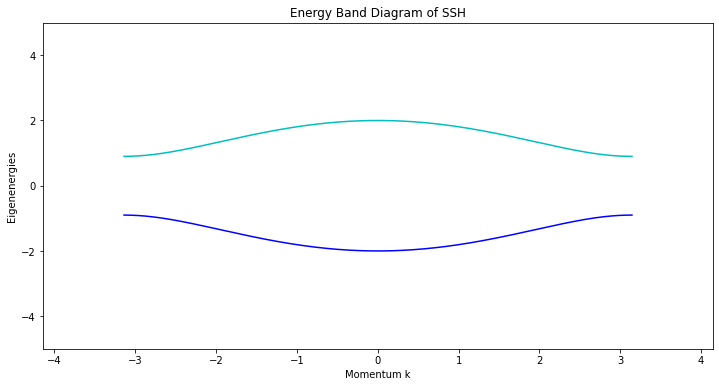

In [10]:
def energyBand(klist, Hamil, var_vec):
    """
    This function computes the energy band diagram of a given system.
    
    Note that this will be used for any Hamiltonian of any dimension with a proper set of variables and momentum tracjector klist.
    The generality of this code will be very handy.
    
    klist is the path on momentum space along which we draw the energy-momentum plot.
    Hamil is the bloch Hamiltonian.
    var_vec is the set of constants in the bloch Hamiltonian and has to be given in a particular order.
    """

    for i,k in enumerate(klist):
      H = Hamil(k, var_vec)
      if i ==0:
        n = H.shape[0]
        evals_mat = np.zeros((len(klist),n))
        evecs_mat = np.empty((len(klist),n),dtype=object)
        evals, ekets = la.eigh(H)
      else:
        evals, ekets = uniTrans(old, H)
      for p in range(n):
        evecs_mat[i][p] = ekets[:,p]
        evals_mat[i][p] = evals[p]
      old = ekets
    return evals_mat,evecs_mat


#1d ssh chain with parameter given below
t = 1;
g = -0.8;
dt = -0.45;
dg = 1.2;

var_list = [t, dt, g, dg]

eps = 0.003
k = 1000
num = 2*k + 1
klist = np.linspace(-np.pi+eps,np.pi+eps,num)



evals_mat,evecs_mat = energyBand(klist, SSH, var_list)

fig, ax = plt.subplots(figsize=(12,6))

colorList = ['b','c','r','g']

for m in range(evecs_mat[0].shape[0]):
    ax.plot(klist, (evals_mat[:,m]), colorList[m])

ax.set_xlabel('Momentum k')
ax.set_ylabel('Eigenenergies')
ax.set_title('Energy Band Diagram of SSH');

plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-5,5)



Now, let's add the SO-coupling. Note that it is now TR invariant.

In [13]:
def SSH_so(k, var_vec):

  t = var_vec[0]
  dt = var_vec[1]
  g = var_vec[2]
  dg = var_vec[3]
  H_ssh = ((t + dt) + (t - dt)*np.cos(k))*band.Sx + (t-dt)*np.sin(k)*band.Sy
  eta = (g-dg + (g+dg)*np.cos(k))*1j*band.Sy + -1j*(g+dg)*np.sin(k)*band.Sx
  H_soc = np.kron(1j*band.Sy, eta)
  return H_soc + np.kron(band.S0, H_ssh)

The energy-momentum graph of the system will allow us to check the validity of unitary transformation function. If it is correctly implemented, then bands represented by different colors must appear according to time reversal symmetry.

(-4.0, 4.0)

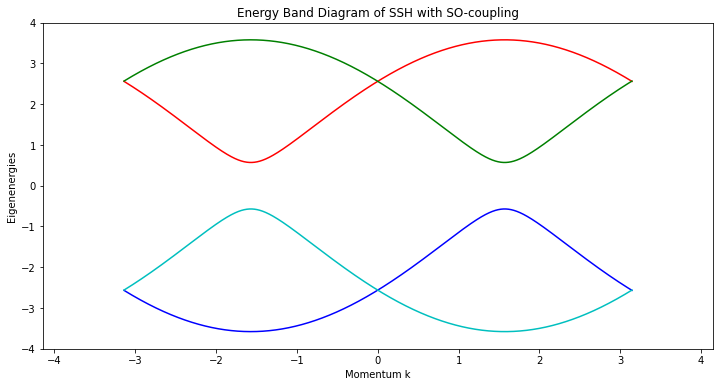

In [14]:
t = 1;
g = -0.8;
dt = -0.45;
dg = 1.2;

var_list = [t, dt, g, dg]

eps = 0.003
k = 1000
num = 2*k + 1
klist = np.linspace(-np.pi+eps,np.pi+eps,num)



evals_mat,evecs_mat = energyBand(klist, SSH_so, var_list)

fig, ax = plt.subplots(figsize=(12,6))

colorList = ['b','c','r','g']

for m in range(evecs_mat[0].shape[0]):
    ax.plot(klist, (evals_mat[:,m]), colorList[m])

ax.set_xlabel('Momentum k')
ax.set_ylabel('Eigenenergies')
ax.set_title('Energy Band Diagram of SSH with SO-coupling');

plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-4,4)



Below, you can see the code for Berry phase. This gives the correct result for any dimension as long as the loop is TR-invariant.

In [15]:
def berry_phase_Tr_line(k_path, Hamil, var_vec, ns):
    '''
    Calculate the Berry phase of some bands of a Hamiltonian along a certain path.

    Parameters
    ----------
    Hamil : function for bloch hamiltonian
    k_path : The path along which to calculate the Berry phase.
    ns : The sequences of bands whose Berry phases are wanted.

    Returns
    -------
    1d ndarray
        The wanted Berry phase of the selected bands in units of 2 pi.
    '''
    final = np.ones(len(ns))
    for i,k in enumerate(k_path):
      H = Hamil(k, var_vec)
      if i ==0:
        n = H.shape[0]
        evals, ekets = la.eigh(H)
        evs = ekets
        result=np.ones(len(ns), dtype=complex)
      else:
        evals, ekets = uniTrans(old, H)
        for j in ns:
          result[j]*=np.vdot(old[:,j],ekets[:,j])
      old=ekets
    for j in ns:
      result[j]*=np.vdot(old[:,j],evs[:,j])
      final[j] = np.real(np.angle(result[j]))/(2*np.pi)                      #in units of 2 pi

    return final

Now, let's go into calculation of invariants in the classification of topological insulators. Let's start with the example of 1D SSH-chain on its own and coupled with SO coupling. 

In [16]:
eps = 0.001
k = 1000
num = 2*k + 1

klist1 = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1]
klist2 = np.linspace(-np.pi+eps, np.pi+eps,num*10)[:-1]


t = 1;
g = 0.8;
dt = -6.0;
dg = -1.0;

var_list = [t, dt, g, dg]


ns = [0,1,2,3]
print(berry_phase_Tr_line(klist1, SSH, var_list, ns[:2]))
print(berry_phase_Tr_line(klist1, SSH_so, var_list, ns))
print(berry_phase_Tr_line(klist2, SSH_so, var_list, ns))

[0.5 0.5]
[ 0.5  0.5 -0.5 -0.5]
[ 0.5  0.5  0.5 -0.5]


(-1.0, 2.0)

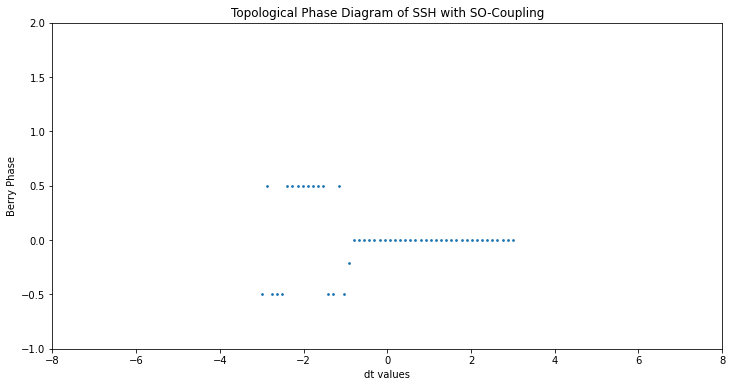

In [17]:
num=50
dt_list = np.linspace(-3, 3,num)
klist1 = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1]
berry_list = []
for c in dt_list:
  var_list[1] = c
  berry_list.append(berry_phase_Tr_line(klist1,SSH_so, var_list, ns)[0])

fig, ax = plt.subplots(figsize=(12,6))


ax.scatter(dt_list, berry_list, s=3)

ax.set_xlabel('dt values')
ax.set_ylabel('Berry Phase')
ax.set_title('Topological Phase Diagram of SSH with SO-Coupling');

plt.xlim(-8, 8)
plt.ylim(-1,2)


One can play with the values to check if it is consistent with the notion of topological invariants, e.g. scaling all the constants or changing any of the parameters without band closing between the Kramer pairs. I have done all of these, it remained consistent. The $\mathbb{Z}_2$ phase transition happens as $dt: 6 \to -6$.

Having studied on 1d systems, we can start looking at 2d systems, which include richer topologies. 

After doing this, we will implement the code for the Chern number using the Wilson lines on the brillouin zone.

I think it's very fascinating that to go to the 2d systems the only change in our code is $k \to (k_x, k_y)$. This is significantly because of the function for unitary Transformation function. Otherwise, we would need to change the way we deal with TR pair configuration depending on the path taken in 2d BZ. The first thing we will try is to reproduce the 2d system with Chern number $\mathcal{C} = +2$ in the paper by KMO. It is Bloch Hamiltonian is given by,

In [19]:
def HamKMO_1(k_vec, var_vec):

    t = var_vec[0]
    t2 = var_vec[1]
    t3 = var_vec[2]
    l = var_vec[3]
    kx= k_vec[0]
    ky = k_vec[1]

    
    H = ((-t*(1+np.cos(ky)+np.cos(2*kx))-t2*np.cos(kx))* band.Sx 
             + (-t*(-np.sin(ky)-np.sin(2*kx))-t2*np.sin(kx))* band.Sy 
             + (-t3*np.sin(2*kx)) * band.Sz )

    return H

In [20]:
#Let's try one Wilson loop for this model and see if it is quantized

eps=0.0001
num = 300

t = 1
t2 = t*(0.4)
t3 = -t*(1.6)
l = t*0.15

var_list = [t, t2, t3, l]

k_traj1 = np.zeros((num-1, 2))
k_traj1[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj1[:,1] = [0]*(num-1)

k_traj2 = np.zeros((num-1, 2))
k_traj2[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj2[:,1] = [np.pi]*(num-1)



ns = [0,1]

print(berry_phase_Tr_line(k_traj1, HamKMO_1, var_list, ns))
print(berry_phase_Tr_line(k_traj2, HamKMO_1, var_list, ns))


[-4.29533506e-17 -9.92762871e-17]
[ 1.03476700e-16 -6.01608723e-18]


Looking at the changes as Wilson lines covers the 2d BZ, we can find the chern number of this system. see for example [[1]](https://arxiv.org/pdf/1508.02967.pdf).

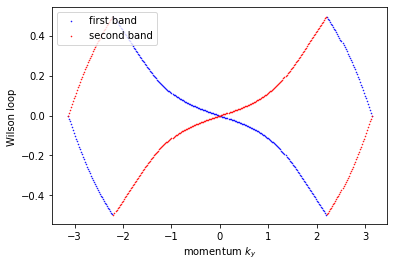

In [21]:
eps = 0.0001
num = 300

klist = np.linspace(-np.pi, np.pi,num)
ns = [0,1]
var_list = [t, t2, t3, l]

chern = []
for ky in klist:
  k_traj = np.zeros((num-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
  k_traj[:,1] = [ky]*(num-1)

  a1, a2 = berry_phase_Tr_line(k_traj, HamKMO_1, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(klist, chern[:,0], c='blue', s=0.3, label='first band')
ax1.scatter(klist, chern[:,1], c='red', s=0.3, label='second band')
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop ')
plt.legend(loc='upper left');
plt.show()



This is the same shape and result as in the paper, $$\mathcal{C} = 2$$ since the winding of 1D berry phase is 2.

Let's continue to verify our implementation using other models. We can also consider Chern Insulator model by Qi, Wung, and Zhang. Its bloch Hamiltonian is given by

In [24]:
def HamQWZ(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    m = var_vec[0]
    a = np.pi/2
    H = np.sin(kx+a)* band.Sx  + np.sin(ky+a)*band.Sy + (m + np.cos(kx+a) + np.cos(ky+a) )*(m - np.cos(kx+a) - np.cos(ky+a))*band.Sz

    return H

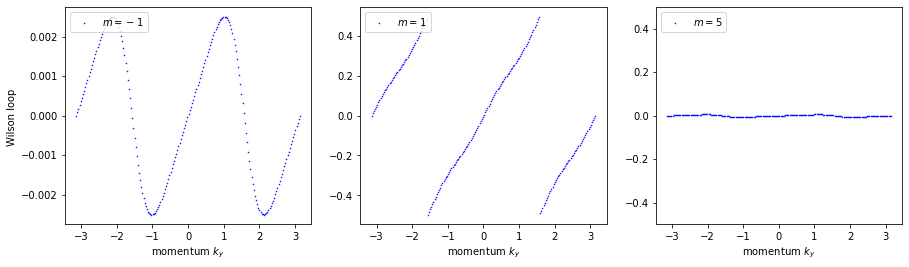

In [25]:
eps = 0.0001
num = 200

m_list=[[-2.5], [-1.0], [2.3]]

klist = np.linspace(-np.pi, np.pi,num)

ns = [0,1]


chern1 = []
chern2 = []
chern3 = []
chern_list = [chern1, chern2, chern3]




for r in range(3):
  for ky in klist:
    k_traj = np.zeros((num-1, 2))
    k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
    k_traj[:,0] = [ky]*(num-1)
    a1, a2 = berry_phase_Tr_line(k_traj, HamQWZ, m_list[r], ns)
    chern_list[r].append([a1,a2])

  chern_list[r] = np.array(chern_list[r])


fig = plt.figure( figsize =(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(klist, chern_list[0][:,0], c='blue', s=0.3, label='$m=-1$')
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop ')

plt.legend(loc='upper left');

ax2 = fig.add_subplot(132)
ax2.scatter(klist, chern_list[1][:,0], c='blue', s=0.3, label='$m=1$')
ax2.set_xlabel('momentum $k_y$')



plt.legend(loc='upper left');

ax3 = fig.add_subplot(133)
ax3.scatter(klist, chern_list[2][:,0], c='blue', s=0.3, label='$m=5$')
ax3.set_xlabel('momentum $k_y$')


plt.legend(loc='upper left');
plt.ylim(-0.5,0.5)
plt.show()


The winding numbers are 1, -1 and 0, respectively. Another system we can look at is another model in KMO paper. Its Bloch Hamiltonian is given by

In [27]:
def HamKMO_2(k_vec, var_list):

    E1 = var_list[0]
    E2 = var_list[1]
    t = var_list[2]
    t_2 = var_list[3] 
    kx = k_vec[0]
    ky = k_vec[1]
    
    H = (-E1 * (np.cos(kx) + np.cos(ky)) * (band.S0 + band.Sz) 
         -E2 * (np.cos(kx) + np.cos(ky)) * (band.S0 - band.Sz) 
         -2*t * (np.cos(kx) - np.cos(ky)) * band.Sx 
         -t_2 * (np.sin(kx)* np.sin(ky)) * band.Sx ) 

    return H

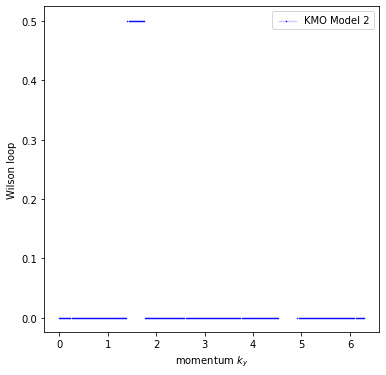

In [28]:
eps = 0.001
num1 = 300
num2 = 300
m_list=[-1, 1, 5]

k3list = np.linspace(0, 2*np.pi,num1)

ns = [0,1]

t = 1                           #given values in the paper
E1 = 0.1*t
E2= -0.3*t
t_2 = 0.8*t

var_list = [E1, E2, t, t_2]

chern = []

for ky in k3list:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)
  a1, a2 = berry_phase_Tr_line(k_traj, HamKMO_2, var_list, ns)
  chern.append([a1,a2])


chern = np.array(chern)


fig = plt.figure( figsize =(6,6))

ax1 = fig.add_subplot(111)
ax1.scatter(k3list, chern[:,0], c='blue', s=0.3, label='KMO Model 2')
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop')


plt.legend(loc='upper right');

plt.show()


Now, the berry phases are quantized since the wavefunctions are real. This is because there is $\sigma_y$ pauli matrix in the hamiltonian.

Having studied all these systems, it is time to go to topological insulators with TR symmetry. We will first look at the first modek in the KMO paper. Its TR invariant version obtained by taking TR partner and coupling it with SO-term. The bloch Hamiltonian is given by

In [30]:
def HamKMO_TR_1(k_vec, var_vec):

    t = var_vec[0]
    t2 = var_vec[1]
    t3 = var_vec[2]
    l = var_vec[3]
    kx = k_vec[0]
    ky = k_vec[1]
  
    H = ((-t*(1+np.cos(ky)+np.cos(2*kx))-t2*np.cos(kx)) * band.S0x  
             + (-t*(-np.sin(ky)-np.sin(2*kx))-t2*np.sin(kx)) * band.S0y 
             + (-t3*np.sin(2*kx)) * band.Szz )
    H_R = -1j*l*((-1/2*np.sin(kx)+np.sin(ky))*1j*band.Sxx+(1/2-1/2*np.cos(kx)+np.cos(ky))*1j*band.Sxy)

    Hf =  H + H_R
    return Hf

For the $\mathbb{Z}_2$ classfication of TR TIs, we need to be extra careful. Since the underlying symmetry is TR when calculation the "individual chern numbers", we need to preserve the TR symmetry. This in the case of 1D system corresponded to taking Tr invariant Wilson loop of one member of Kramer pair. We can simply use the same Berry phase code for TR invariant lines in 2d. However, when we try to calculate Wilson loop along some line that is not tr invariant, e.g. $k_x = 0.4$ line, we cannot consistently go along one member of Kramer pair since, there is no dirac cone to pass through. But if we have $U(2)$-invariant formulation of Wilson loop along any line, then we can use it. Such a formulation is done by Bernevig et al, [see](https://arxiv.org/abs/1101.2011). This kind of convenient calculation is owing to the wannier center formulation of $\mathbb{Z}_2$ topological invariant of TR TI's. We will use this to calculate $\mathbb{Z}_2$ invariants, providing further consistency checks on our calculations. The code which implements the computation above is given by

In [31]:
def Z2_invariant(k_path, Hamil, var_vec, ns):
    '''
    all the parameters have the same functionality as in the case of berry_phase except for ns.
    This is the index of bands. But, this time it must be given in pairs, e.g. ns=[0,1]  or [0,1, 2, 3, 4,6].
    Namely, if we have ns = [0,1], the computation will be done over 1st and 2nd band corresponding to first Kramer pair.
    '''

    for i,k_vec in enumerate(k_path):
      H = Hamil(k_vec, var_vec)
      W = np.zeros((len(ns),len(ns)), dtype=complex)
      if i ==0:
        evals, ekets = la.eigh(H)
        result=np.eye(len(ns), dtype=complex)
        evs = ekets
      else:
        evals, ekets = la.eigh(H)
        for u in ns:
          for v in ns:
            W[u][v] = np.vdot(old[:,u], ekets[:,v])
        np.set_printoptions(suppress=True)
        np.set_printoptions(precision=6)
        #print(W)

        result = np.dot(result, W)

      old=ekets

    for u in ns:
      for v in ns:
        W[u][v] = np.vdot(old[:,u], evs[:,v])
    result = np.dot(result, W)
    
    r_list = []
    for i in ns:
        r_list.append(np.angle(la.eig(result)[0][i])/(2*np.pi))

    return r_list                              #taking the eigenvalueso of Wilson loop

In [32]:
eps = 0.0001
num1 = 320
num2 = 1000

klist = [0, np.pi]


t = 1
t2 = t*(0.4)
t3 = -t*(1.6)
l = t*9
var_list = [t, t2, t3, l]
ns = [0,1]

chern = []
for kx in klist:
  k_traj = np.zeros((num1-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num1)[:-1] 
  k_traj[:,1] = [kx]*(num1-1)

  a1, a2 = Z2_invariant(k_traj, HamKMO_TR_1, var_list, ns)
  chern.append([(a1),(a2)])


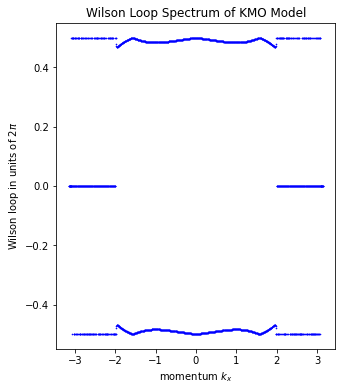

In [33]:
eps = 0.0001
num1 = 120
num2 = 1000

klist = np.linspace(-np.pi, np.pi,num2)


t = 1
t2 = t*(0.4)
t3 = -t*(1.7)
l = t*9
var_list = [t, t2, t3, l]
ns = [0,1]

chern = []
for kx in klist:
  k_traj = np.zeros((num1-1, 2))
  k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num1)[:-1] 
  k_traj[:,0] = [kx]*(num1-1)

  a1, a2 = Z2_invariant(k_traj, HamKMO_TR_1, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)


fig = plt.figure(figsize =(5,6))
ax1 = fig.add_subplot(111)

ax1.scatter(klist, chern[:,0], c='blue', s=0.4)
ax1.scatter(klist, chern[:,1], c='blue', s=0.4)
ax1.set_xlabel('momentum $k_x$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of KMO Model')

plt.show()



In [34]:
def k_path(point_list, loop, N):
  '''
  This function produces the path connecting the set of points given in the point_list input.
  The path will be closed if loop is True and will be open if false.
  N is the number of points in the path.
  One can check the stability of the result by increasing N further.
  '''
  k_trajectory = np.empty([0,2])
  for i in range(len(point_list)-1):
    segment = np.linspace(point_list[i], point_list[i+1], N)[1:]
    k_trajectory = np.append(k_trajectory, segment, axis=0)
  if loop:
    segment = np.linspace(point_list[-1], point_list[0], N)[1:]
    k_trajectory = np.append(k_trajectory, segment, axis=0)
  return k_trajectory
    

(-20.0, 20.0)

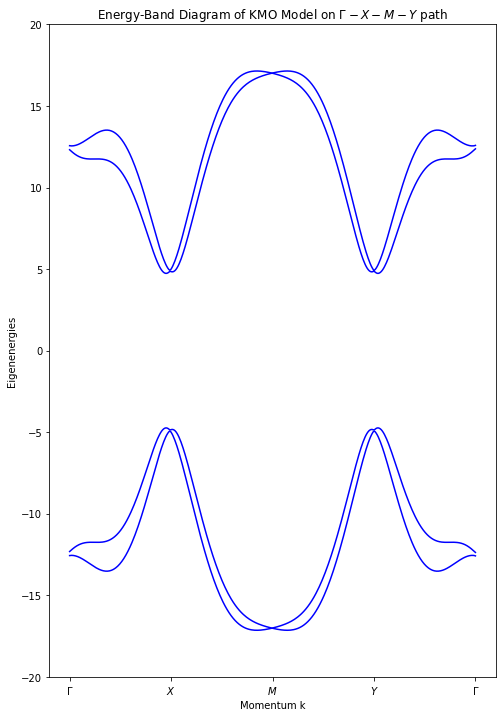

In [35]:
t = 5
t2 = t*(0.4)
t3 = -t*(1.6)
l = t*0.15

var_list = [t, t2, t3, l]
N=200

klist_sqr = k_path([(0,0),(np.pi,0),(np.pi,np.pi),(0,np.pi)], True, N)

klist_sqr1 = k_path([(-np.pi,-np.pi*0.2),(0,0),(np.pi,np.pi*0.2)], False, N)

evals_mat,evecs_mat = energyBand(klist_sqr1, HamKMO_TR_1, var_list)

fig, ax = plt.subplots(figsize=(8,12))


kplot_list = np.linspace(0,4,len(klist_sqr1))

colorList = ['b','c','r','g']

for m in range(evecs_mat[0].shape[0]):
  ax.plot(kplot_list, (evals_mat[:,m]), colorList[0])



ax.set_xlabel('Momentum k')
ax.set_ylabel('Eigenenergies')
ax.set_title('Energy-Band Diagram of KMO Model on $\Gamma-X-M-Y$ path');
positions = (0, 1, 2, 3, 4)
labels = ("$\Gamma$", "$X$", "$M$", "$Y$", "$\Gamma$")
plt.xticks(positions, labels)
plt.ylim(-20,20)



Another model of TR TI in KMO paper is the following.

In [37]:
def HamKMO_TR_2(k_vec, var_vec):

    E1 = var_vec[0] 
    E2 = var_vec[1] 
    t = var_vec[2] 
    t_2 = var_vec[3] 
    l = var_vec[4] 
    kx = k_vec[0]
    ky = k_vec[1]

    H = (-E1 * (np.cos(kx) + np.cos(ky)) * (band.S00 + band.S0z)  
            -E2 * (np.cos(kx) + np.cos(ky)) * (band.S00 - band.S0z) 
             -2*t * (np.cos(kx) - np.cos(ky)) * band.S0x 
             -t_2 * (np.sin(kx)* np.sin(ky)) * band.S0x )
    
    H_mix = -l*(np.sin(kx)*band.Sy0 + np.sin(ky) * band.Sx0)

    return H + H_mix

(-20.0, 20.0)

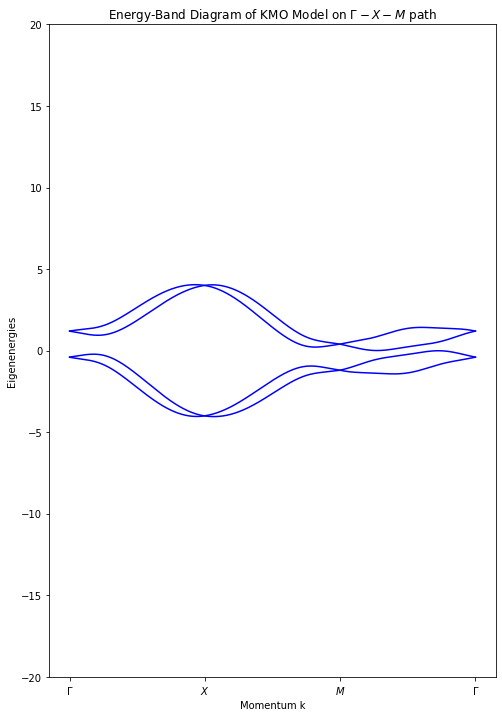

In [38]:
t = 1
E1 = t*(0.1)
E2 = -t*(0.3)
t_2 = t*0.8
l = t*0.4

var_list = [E1, E2, t, t_2, l]

N=200

klist_sqr = k_path([(0,0),(np.pi,0),(np.pi, np.pi)], True, N)

evals_mat,evecs_mat = energyBand(klist_sqr, HamKMO_TR_2, var_list)

fig, ax = plt.subplots(figsize=(8,12))


kplot_list = np.linspace(0,3,len(klist_sqr))

colorList = ['b','c','r','g']

for m in range(evecs_mat[0].shape[0]):
  ax.plot(kplot_list, (evals_mat[:,m]), colorList[0])



ax.set_xlabel('Momentum k')
ax.set_ylabel('Eigenenergies')
ax.set_title('Energy-Band Diagram of KMO Model on $\Gamma-X-M$ path');
positions = (0, 1, 2, 3)
labels = ("$\Gamma$", "$X$", "$M$", "$\Gamma$")
plt.xticks(positions, labels)
plt.ylim(-20,20)



Let's look at the Wilson loop spectrum of this model.

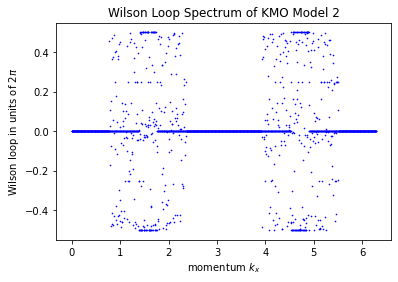

In [39]:
eps = 0.0001
num1 = 100

num2 = 1000

klist = np.linspace(0, 2*np.pi,num2)


t = 200
E1 = t*(0.1)
E2 = -t*(0.3)
t_2 = t*0.8
l = t*0.4



var_list = [E1, E2, t, t_2, l]
ns = [0,1]

chern = []
for kx in klist:
  k_traj = np.zeros((num1-1, 2))
  k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num1)[:-1] 
  k_traj[:,0] = [kx]*(num1-1)

  a1, a2 = Z2_invariant(k_traj, HamKMO_TR_2, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(klist, chern[:,0], c='blue', s=0.4)
ax1.scatter(klist, chern[:,1], c='blue', s=0.4)
ax1.set_xlabel('momentum $k_x$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of KMO Model 2')

plt.show()



Around some region above it is highly oscillating, this generally signals that it is gapless around this region. To confirm this, look at the energy diagram in this region

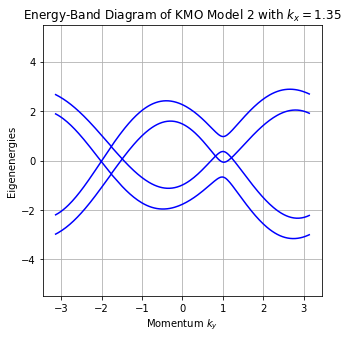

In [40]:
t = 1
E1 = t*(0.1)
E2 = -t*(0.3)
t_2 = t*0.8
l = t*0.4

var_list = [E1, E2, t, t_2, l]

N=200

klist_sqr = k_path([(1.35,-np.pi),(1.35,np.pi)], False, N)

evals_mat,evecs_mat = energyBand(klist_sqr, HamKMO_TR_2, var_list)

fig, ax = plt.subplots(figsize=(5,5))

kplot_list = np.linspace(-np.pi,np.pi,len(klist_sqr))

colorList = ['b','c','r','g']
for m in range(evecs_mat[0].shape[0]):
  ax.plot(kplot_list, (evals_mat[:,m]), colorList[0])



ax.set_xlabel('Momentum $k_y$')
ax.set_ylabel('Eigenenergies')
ax.set_title('Energy-Band Diagram of KMO Model 2 with $k_x = 1.35$');

plt.ylim(-5.5,5.5)
plt.grid(True)

We could also use gap function to check its gap

In [41]:
def gap(Ham, var_vec, N):
  kx_path = np.linspace(-np.pi, np.pi, N)
  ky_path = np.linspace(-np.pi, np.pi, N)
  H = Ham((0,0), var_vec)
  n = H.shape[0]
  evals = la.eigh(H)[0]
  gap = np.abs(evals[n//2]- evals[n//2 -1])
  for kx in kx_path:
    for ky in ky_path:
      evals = la.eigh(Ham((kx,ky), var_vec))[0]
      gap_n = np.abs(evals[n//2]- evals[n//2 -1])
      if gap_n < gap:
        gap = gap_n
  return gap

In [43]:
t = 1
E1 = t*(0.1)
E2 = -t*(0.3)
t_2 = t*0.8
l = t*0.4

var_list = [E1, E2, t, t_2, l]
N=200

print(gap(HamKMO_TR_2, var_list, N))

#It gets even smaller as N increases

0.0002079159337288472


This is in contradiction to it being insulator???

Another system we can look at is a variation of BHZ model that includes spin-mixing term that breaks inversion symmetry. Recall that the inversion symmetry in this system is given by
$$\sigma_x \times \mathbb{1}$$ where $\sigma_x$ acts on the orbital space, $\mathbb{1}$ on the spin space.

In [44]:
def HamBHZ(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    A = var_vec[0]
    B= var_vec[1]
    C = var_vec[2]
    D = var_vec[3]
    M = var_vec[4]
    delta = var_vec[5]

    
    E_k = C- 2*D*(2- np.cos(kx) - np.cos(ky))
    d_1 = A*np.sin(kx)
    d_2 = A*np.sin(ky) 
    d_3 = -2*B*(2 -M/(2*B)-np.cos(kx) - np.cos(ky))
    H = E_k*band.S00 + d_1*band.Szx + d_2*band.S0y + d_3*band.S0z
    
    # term breaking the inversion symmetry
    H_int = delta*(-band.Syy)                         

    return H + H_int



Now, we can look at different $\mathbb{Z}_2$-phases of this model by looking at the quantity given in the paper by Bernevig et al. The phases are distinguished by two sets of parameters below.

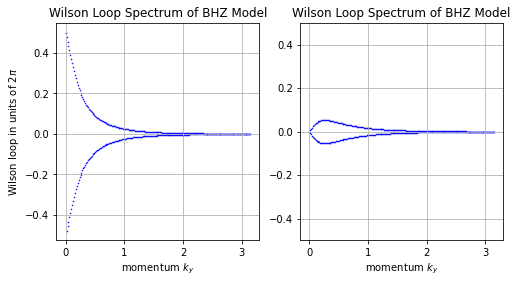

In [45]:
eps = 0.001
num = 200

A=-13.68
B=-16.9
C=-0.0263 
D=-0.514
M=-2.058
delta=1.20


var_list = [A,B,C,D, M, delta]

k3list = np.linspace(0, np.pi,num)

ns = [0,1]
num2 = 200
chern = []
for ky in k3list:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, HamBHZ, var_list, ns)
  chern.append([(a1),(a2)])

chern = np.array(chern)



fig = plt.figure( figsize =(8,4))
ax1 = fig.add_subplot(121)

ax1.scatter(k3list, chern[:,0], c='blue', s=0.3)
ax1.scatter(k3list, chern[:,1], c='blue', s=0.3)
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of BHZ Model')
plt.grid(True)


A=-14.48
B=-18.0
C=-0.018
D=-0.594
M=2.766
delta=1.20


var_list = [A,B,C,D, M, delta]


chern = []
for ky in k3list:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, HamBHZ, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)

ax2 = fig.add_subplot(122)

ax2.scatter(k3list, chern[:,0], c='blue', s=0.3)
ax2.scatter(k3list, chern[:,1], c='blue', s=0.3)
ax2.set_xlabel('momentum $k_y$')

ax2.set_title('Wilson Loop Spectrum of BHZ Model')

plt.ylim(-0.5,0.5)
plt.grid(True)
plt.show()

First is in the non-trivial $\mathbb{Z}_2$-phase since any line crosses odd number of points. The second case is trivial since any line crosses even number of points.

Finally, we can try our codes on Kane-Mele model for QSHE. 

However, there is one issue we need to consider. The underlying BZ is conventially hexagon. But we can choose it to be parallelogram. But with the numerical implementation above, it would be easier if we have square BZ. This can be accomplished by a change of basis and rescaling,

$$
k_1 \to \vec{k} \cdot \vec{a}_1 = \frac{3}{2}k_1 + \frac{\sqrt{3}}{2}k_2 \\
k_2 \to \vec{k} \cdot \vec{a}_2 = \frac{3}{2}k_1 - \frac{\sqrt{3}}{2}k_2
$$


With this change, the reciprocal lattice vectors become those of square BZ. Note that this is convention is used in writing the Bloch Hamiltonian for Kane-Mele model. Its bloch hamiltonian in this convention is given by the following function.

In [47]:
def KaneMele(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    t = var_vec[0]
    l_v = var_vec[1] 
    l_R = var_vec[2] 
    l_SO = var_vec[3] 

    d_1 = t*(1 + 2*np.cos((kx-ky)/2)*np.cos((kx+ky)/2))
    d_2 = l_v
    d_3 = l_R*(1 - np.cos((kx-ky)/2)*np.cos((kx+ky)/2))
    d_4 = -np.sqrt(3)*l_R*np.sin((kx-ky)/2)*np.sin((kx+ky)/2)
    d_12 = -2*t*np.cos((kx-ky)/2)*np.sin((kx+ky)/2)
    d_15 = l_SO * (2*np.sin(2*(kx-ky)/2) - 4*np.sin((kx-ky)/2)*np.cos((kx+ky)/2))
    d_23 = -l_R * np.cos((kx-ky)/2)*np.sin((kx+ky)/2)
    d_24 = np.sqrt(3)*l_R * np.sin((kx-ky)/2)*np.cos((kx+ky)/2)

    H =  (d_1*band.G_1 + d_2*band.G_2 + d_3*band.G_3 + d_4*band.G_4 
            + d_12*band.G_12 + d_15*band.G_15 + d_23*band.G_23 + d_24*band.G_24)

    return H

Going from Fu-Kane convention to ours, One needs to apply the change $$x \to \frac{k_x-k_y}{2}, \qquad y \to \frac{k_x+k_y}{2}$$ for our convention of converting to the square BZ.

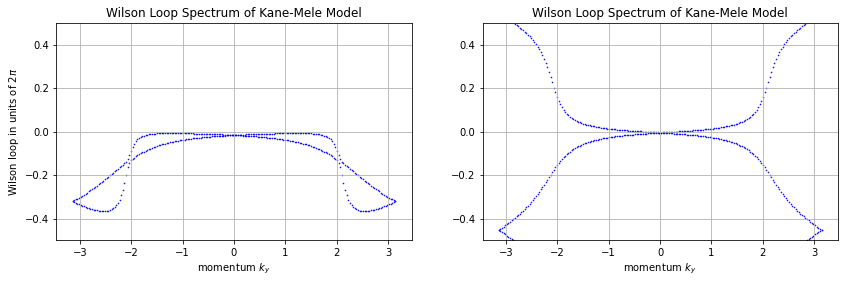

In [48]:
eps = 0.001
num1 = 150
num2 = 700

t = 1
l_v = (0.4)*t
l_R = (0.05)*t
l_SO = (0.06)*t

var_list = [t, l_v, l_R, l_SO]

klist = np.linspace(-np.pi, np.pi,num)

ns = [0,1]

chern = []
for ky in klist:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, KaneMele, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)


fig = plt.figure( figsize =(14,4))
ax1 = fig.add_subplot(121)

ax1.scatter(klist, chern[:,0], c='blue', s=0.33)
ax1.scatter(klist, chern[:,1], c='blue', s=0.33)
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of Kane-Mele Model')



plt.ylim(-0.5,0.5)
plt.grid(True)


t = 1
l_v = (0.1)*t
l_R = (0.05)*t
l_SO = (0.06)*t

var_list = [t, l_v, l_R, l_SO]




chern = []
for ky in klist:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, KaneMele, var_list, ns)
  chern.append([(a1),(a2)])

chern = np.array(chern)



ax2 = fig.add_subplot(122)

ax2.scatter(klist, chern[:,0], c='blue', s=0.33, label='first')
ax2.scatter(klist, chern[:,1], c='blue', s=0.33, label='second')
ax2.set_xlabel('momentum $k_y$')

ax2.set_title('Wilson Loop Spectrum of Kane-Mele Model')



plt.ylim(-0.5,0.5)
plt.grid(True)
plt.show()

First is in the trivial $\mathbb{Z}_2$-phase since any line crosses even number of points. The second case is non-trivial since any line crosses odd number of points. This agrees with the result from the paper by Kane and Mele.

Note that this is the reflected version of the result in  Bernevig paper. But this does not change the result due to $\mathbb{Z}_2$ nature of the system. But this might have arisen from one error in deriving the formula in their paper, which amounts to conjugating the dot product.

Finally, we will look at the $\mathbb{Z}_2$ invariant of the third model of kmo paper. Its bloch hamiltonian is given by

In [49]:
def KMO3(k_vec, var_vec):
    """
    This function computes the energy band diagram of a given system.
    
    Note that depending on the hamiltonian, the first part changes
    
    """
    kx = k_vec[0]
    ky = k_vec[1]
    t_s = var_vec[0]
    t_p = var_vec[1] 
    t_2 = var_vec[2] 
    a = var_vec[3]
    rho = var_vec[4]
    eps = var_vec[5]
    l = var_vec[6]


    #negative x-spin
    h_k_neg = (1/2*(1 + a*(np.cos(ky) - 1j*np.sin(ky)) + np.cos(kx-eps) -1j*np.sin(kx-eps))*(t_s + t_p)*band.S0
                -1/2*(-1/2 + a*(np.cos(ky) - 1j*np.sin(ky)) - 1/2*(np.cos(kx-eps) -1j*np.sin(kx-eps)))*(t_s - t_p) * band.Sz
                + np.sqrt(3)/4*(-1 + (np.cos(kx-eps) -1j*np.sin(kx-eps)))*(t_s - t_p)*band.Sx )
    
    h_kc_neg = np.transpose(np.conjugate(h_k_neg))
    Hk_neg = np.block([[np.zeros((2,2)), h_k_neg],[h_kc_neg, np.zeros((2,2))]])

    H1_k_neg = -t_2/4*(np.sin(kx-eps - ky) + np.sin(kx-eps) - rho*np.sin(ky))* band.Szy
    H_neg = Hk_neg + H1_k_neg

    
    #positive x spin
    h_k_pos = ( 1/2*(1 + a*(np.cos(-ky) - 1j*np.sin(-ky)) + np.cos(-kx+eps) -1j*np.sin(-kx+eps))*(t_s + t_p) * band.S0
                -1/2*(-1/2 + a*(np.cos(-ky) - 1j*np.sin(-ky)) - 1/2*(np.cos(-kx+eps) -1j*np.sin(-kx+eps)))*(t_s - t_p) * band.Sz
                + np.sqrt(3)/4*(-1 + (np.cos(-kx+eps) -1j*np.sin(-kx+eps)))*(t_s - t_p)*band.Sx )
    
    h_kc_pos = np.transpose(np.conjugate(h_k_pos))
    Hk_pos = np.block([[np.zeros((2,2)), h_k_pos],[h_kc_pos, np.zeros((2,2))]])

    H1_k_pos = -t_2/4*(np.sin(-kx+eps + ky) + np.sin(-kx+eps) - rho*np.sin(-ky))* band.Szy
    H_pos = Hk_pos + H1_k_pos
    H_pos = np.conjugate(H_pos)

    H_mix = l*np.sin(kx) * band.S00

    return np.block([[H_pos, np.zeros((4,4))],[np.zeros((4,4)), H_neg]]) + np.kron(band.Sy, H_mix)


In [52]:
eps=0.0001
num = 401
ns = [0,1]

t = 1
t2 = t*(0.4)
t3 = -t*(1.6)
l = t*9
var_list = [t, t2, t3, l]



k_traj = np.zeros((num-1, 2))
k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj[:,1] = [np.pi*0]*(num-1)
LBO_inv = berry_phase_Tr_line(k_traj, HamKMO_TR_1, var_list, ns)[0]
print(f"The LBO invariant for the line k_y=0 is {LBO_inv:.5f}")



k_traj = np.zeros((num-1, 2))
k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj[:,1] = [np.pi]*(num-1)
LBO_inv = berry_phase_Tr_line(k_traj, HamKMO_TR_1, var_list, ns)[0]
print(f"The LBO invariant for the line k_y=\u03C0 is {LBO_inv:.5f}")



k_traj = np.zeros((num-1, 2))
k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj[:,0] = [np.pi*0]*(num-1)
LBO_inv = berry_phase_Tr_line(k_traj, HamKMO_TR_1, var_list, ns)[0]
print(f"The LBO invariant for the line k_x=0 is {LBO_inv:.5f}")



k_traj = np.zeros((num-1, 2))
k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
k_traj[:,0] = [np.pi]*(num-1)
LBO_inv = berry_phase_Tr_line(k_traj, HamKMO_TR_1, var_list, ns)[0]
print(f"The LBO invariant for the line k_x=\u03C0 is {LBO_inv:.5f}")


The LBO invariant for the line k_y=0 is -0.00000
The LBO invariant for the line k_y=π is -0.50000
The LBO invariant for the line k_x=0 is -0.50000
The LBO invariant for the line k_x=π is 0.00000


In [53]:
def gap(Ham, var_vec, N):
  kx_path = np.linspace(-np.pi, np.pi, N)
  ky_path = np.linspace(-np.pi, np.pi, N)
  H = Ham((0,0), var_vec)
  n = H.shape[0]
  evals = la.eigh(H)[0]
  gap = np.abs(evals[n//2]- evals[n//2 -1])
  for kx in kx_path:
    for ky in ky_path:
      evals = la.eigh(Ham((kx,ky), var_vec))[0]
      gap_n = np.abs(evals[n//2]- evals[n//2 -1])
      if gap_n < gap:
        gap = gap_n
  return gap

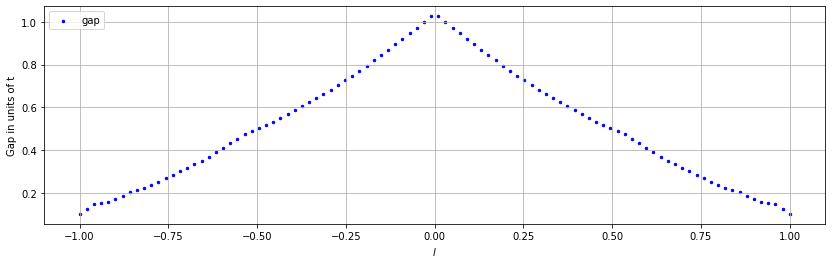

In [55]:
t = 1
t2 = t*(0.4)
t3 = -t*(1.6)
l = t*0.15
var_list = [t, t2, t3, l]

N=100
num = 100
gap_list = []
L_list = np.linspace(-1,1, num)
for i in L_list:
  l = i
  var_list = [t, t2, t3, l]
  gap_list.append(gap(HamKMO_TR_1, var_list, N))



fig = plt.figure( figsize =(14,4))
ax1 = fig.add_subplot(111)
ax1.scatter(L_list, gap_list, c='blue', s=6, label='gap')
plt.xlabel('$l$')
plt.ylabel('Gap in units of t')
plt.legend(loc='upper left');
plt.grid(True)
plt.show()


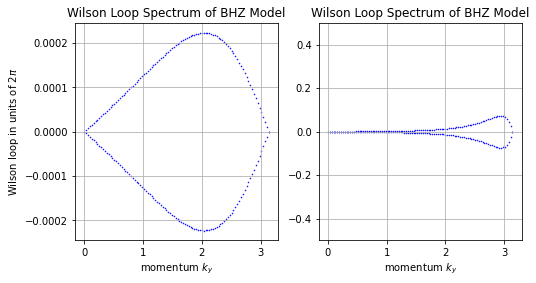

In [56]:
eps = 0.001
num = 100

A=-13.68
B=-16.9
C=-0.0263 
D=-0.514
M=B*(16)
delta=1.20*0


var_list = [A,B,C,D, M, delta]

k3list = np.linspace(0, np.pi,num)

ns = [0,1]
num2 = 200
chern = []
for ky in k3list:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, HamBHZ, var_list, ns)
  chern.append([(a1),(a2)])

chern = np.array(chern)



fig = plt.figure( figsize =(8,4))
ax1 = fig.add_subplot(121)

ax1.scatter(k3list, chern[:,0], c='blue', s=0.3)
ax1.scatter(k3list, chern[:,1], c='blue', s=0.3)
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of BHZ Model')
plt.grid(True)


A=-14.48
B=-18.0
C=-0.018
D=-0.594
M=8.1*B
delta=0


var_list = [A,B,C,D, M, delta]


chern = []
for ky in k3list:
  k_traj = np.zeros((num2-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num2)[:-1] 
  k_traj[:,1] = [ky]*(num2-1)

  a1, a2 = Z2_invariant(k_traj, HamBHZ, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)

ax2 = fig.add_subplot(122)

ax2.scatter(k3list, chern[:,0], c='blue', s=0.3)
ax2.scatter(k3list, chern[:,1], c='blue', s=0.3)
ax2.set_xlabel('momentum $k_y$')

ax2.set_title('Wilson Loop Spectrum of BHZ Model')

plt.ylim(-0.5,0.5)
plt.grid(True)
plt.show()

In [58]:
def HamKMO_2(k_vec, var_vec):

    E1 = var_vec[0] 
    E2 = var_vec[1] 
    t = var_vec[2] 
    t_2 = var_vec[3] 
    l = var_vec[4] 
    kx = k_vec[0]
    ky = k_vec[1]

    H = (-E1 * (np.cos(kx) + np.cos(ky))*(band.S0 + band.Sz)  
             -E2 * (np.cos(kx) + np.cos(ky))*(band.S0 - band.Sz) 
             -2*t * (np.cos(kx) - np.cos(ky))*band.Sx 
             -t_2 * (np.sin(kx)* np.sin(ky))*band.Sx ) 

    return H

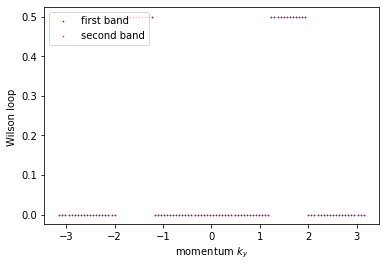

In [59]:
eps = 0.0001
num = 100

t = 1
E1 = -t*(5)
E2 = -t*(3.3)
t_2 = t*1.8
l = t*0.4

klist = np.linspace(-np.pi, np.pi,num)
ns = [0,1]

var_list = [E1, E2, t, t_2, l]

chern = []
for ky in klist:
  k_traj = np.zeros((num-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
  k_traj[:,1] = [ky]*(num-1)

  a1, a2 = berry_phase_Tr_line(k_traj, HamKMO_2, var_list, ns)
  chern.append([(a1),(a2)])


chern = np.array(chern)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(klist, chern[:,0], c='blue', s=0.3, label='first band')
ax1.scatter(klist, chern[:,1], c='red', s=0.3, label='second band')
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop ')
plt.legend(loc='upper left');
plt.show()



In [60]:
def HamQWZ(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    m = var_vec[0]
    a = np.pi/2
    H = np.cos(kx)*band.Sx  + np.cos(ky)*band.Sy + (m - np.sin(kx) - np.sin(ky) )* (m + np.sin(kx) + np.sin(ky))*band.Sz

    return H

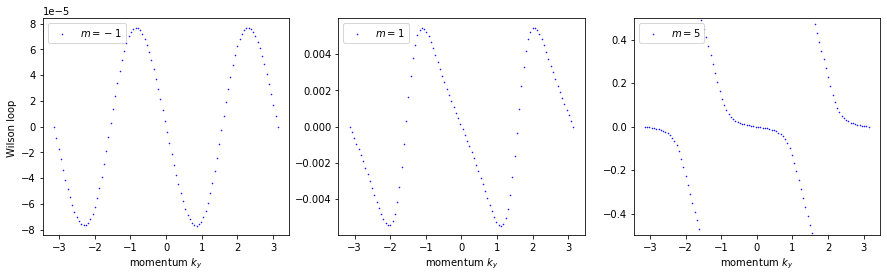

In [61]:
eps = 0.0001
num = 100

m_list=[[-4.02], [-2.31], [-1.8]]

klist = np.linspace(-np.pi, np.pi,num)

ns = [0,1]


chern1 = []
chern2 = []
chern3 = []
chern_list = [chern1, chern2, chern3]




for r in range(3):
  for ky in klist:
    k_traj = np.zeros((num-1, 2))
    k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num)[:-1] 
    k_traj[:,1] = [ky]*(num-1)
    a1, a2 = berry_phase_Tr_line(k_traj, HamQWZ, m_list[r], ns)
    chern_list[r].append([a1,a2])

  chern_list[r] = np.array(chern_list[r])


fig = plt.figure( figsize =(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(klist, chern_list[0][:,0], c='blue', s=0.3, label='$m=-1$')
ax1.set_xlabel('momentum $k_y$')
ax1.set_ylabel('Wilson loop ')

plt.legend(loc='upper left');

ax2 = fig.add_subplot(132)
ax2.scatter(klist, chern_list[1][:,0], c='blue', s=0.3, label='$m=1$')
ax2.set_xlabel('momentum $k_y$')



plt.legend(loc='upper left');

ax3 = fig.add_subplot(133)
ax3.scatter(klist, chern_list[2][:,0], c='blue', s=0.3, label='$m=5$')
ax3.set_xlabel('momentum $k_y$')


plt.legend(loc='upper left');
plt.ylim(-0.5,0.5)
plt.show()


In [62]:
def HamQWZ_TR(k_vec, var_vec):
    kx = k_vec[0]
    ky = k_vec[1]
    m = var_vec[0]
    v = var_vec[1]
    a = np.pi/2
    H = np.cos(kx)*band.Sx0  + np.cos(ky)*band.Syz + (m - np.sin(kx) - np.sin(ky) )* (m + np.sin(kx) + np.sin(ky))*band.Sz0
    H_int = 0.0*np.sin(kx)*band.Szx
    ky = ky*2
    H1 = np.cos(kx)*band.Sx0  + np.cos(ky)*band.Syz + (m - np.sin(kx) - np.sin(ky) )* (m + np.sin(kx) + np.sin(ky))*band.Sz0
    H_int1 = 0.1*np.sin(kx + ky)*band.Szx
    return (1-v)*(H + H_int) + v*(H1 + H_int1)

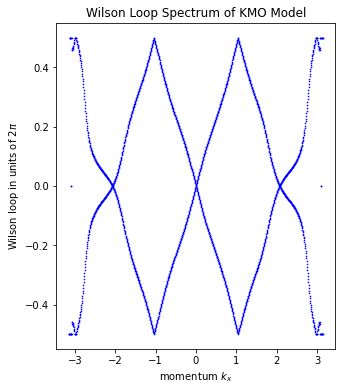

In [63]:
eps = 0.0001
num1 = 120
num2 = 1000
klist = np.linspace(-np.pi, np.pi,num2)

m = -1
v=0.51
var_list = [m, v]
ns = [0,1]

chern = []
for kx in klist:
  k_traj = np.zeros((num1-1, 2))
  k_traj[:,0] = np.linspace(-np.pi+eps, np.pi+eps,num1)[:-1] 
  k_traj[:,1] = [kx]*(num1-1)

  a1, a2 = Z2_invariant(k_traj, HamQWZ_TR, var_list, ns)
  chern.append([(a1),(a2)])

chern = np.array(chern)

fig = plt.figure(figsize =(5,6))
ax1 = fig.add_subplot(111)

ax1.scatter(klist, chern[:,0], c='blue', s=0.4)
ax1.scatter(klist, chern[:,1], c='blue', s=0.4)
ax1.set_xlabel('momentum $k_x$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of KMO Model')
plt.show()

In [65]:
m = -1
v = 0.51
var_list = [m, v]
N = 100
print(gap(HamQWZ_TR, var_list, N))

0.0365135396396684


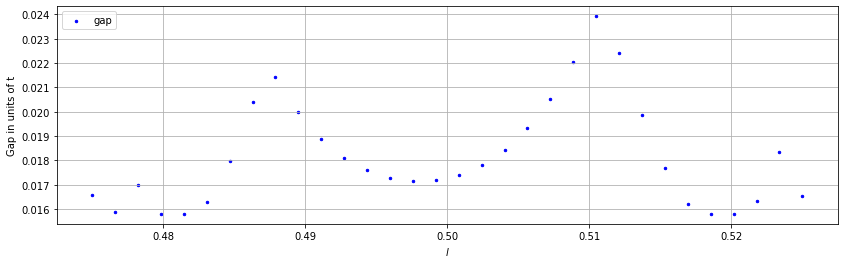

In [67]:
m = -1
v=0.95
var_list = [m, v]

N=200
num = 32
gap_list = []
L_list = np.linspace(0.475,0.525, num)
for i in L_list:
  v = i
  var_list = [m, v]
  gap_list.append(gap(HamQWZ_TR, var_list, N))



fig = plt.figure( figsize =(14,4))
ax1 = fig.add_subplot(111)
ax1.scatter(L_list, gap_list, c='blue', s=6, label='gap')
plt.xlabel('$l$')
plt.ylabel('Gap in units of t')
plt.legend(loc='upper left');
plt.grid(True)
plt.show()


In [68]:
def HamQWZ_TR(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    m = var_vec[0]
    H = np.cos(kx)*band.Sx0  + np.cos(ky)*band.Syz + (m - np.sin(kx) - np.sin(ky) )* (m + np.sin(kx) + np.sin(ky))*band.Sz0

    return H

In [69]:
def HamQWZ_TR2(k_vec, var_vec):

    kx = k_vec[0]
    ky = k_vec[1]
    t = var_vec[1]
    t2 = var_vec[2]
    H = t*np.kron(band.S0, HamQWZ_TR(k_vec, var_vec[:1]))
    H_mix = t2*np.kron(band.Sx, HamQWZ_TR(k_vec, var_vec[-1:]))

    return H + H_mix

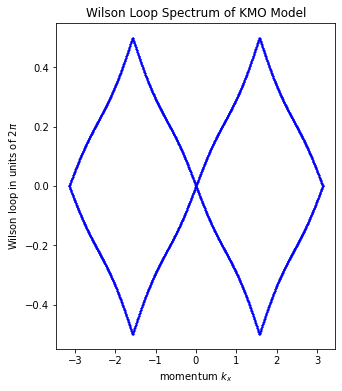

In [70]:
eps = 0.0001
num1 = 120
num2 = 1200

klist = np.linspace(-np.pi, np.pi,num2)


m = -1.0
t = -2.9
t2 = -2.4
m2 = -1.0

var_list = [m, t, t2, m2]
ns = [0,1,2,3]

chern = []
for kx in klist:
  k_traj = np.zeros((num1-1, 2))
  k_traj[:,1] = np.linspace(-np.pi+eps, np.pi+eps,num1)[:-1] 
  k_traj[:,0] = [kx]*(num1-1)

  a = Z2_invariant(k_traj, HamQWZ_TR2, var_list, ns)
  chern.append(a)


chern = np.array(chern)


fig = plt.figure(figsize =(5,6))
ax1 = fig.add_subplot(111)

ax1.scatter(klist, chern[:,0], c='blue', s=0.4)
ax1.scatter(klist, chern[:,1], c='blue', s=0.4)
ax1.scatter(klist, chern[:,2], c='blue', s=0.4)
ax1.scatter(klist, chern[:,3], c='blue', s=0.4)
ax1.set_xlabel('momentum $k_x$')
ax1.set_ylabel('Wilson loop in units of $2\pi$')
ax1.set_title('Wilson Loop Spectrum of KMO Model')

plt.show()

